# Kapitel 13 - Hyperparameteroptimierung mit Keras

In [1]:
#check if gpu is available
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

## 13.1. Kapitelübersicht <a class="anchor" id="13-1"/>

TODO

<b>Abschnittsübersicht</b><br>

[13.1. Kapitelübersicht](#13-1)<br>


Am Ende dieses Kapitel werden wir folgende Themen behandelt und/oder vertieft haben:
- Alternativer Aufbau von Neuronalen Netzen in Keras

## 13.2. Hyperparameteroptimierung

In [1]:
from keras import models
from keras import layers
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import Dropout
from keras.layers.core import Dense, Dropout, Activation

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


MEHR? Wir befolgen nun den Code des <a href="https://github.com/maxpumperla/hyperas">hyperas-Beispiel</a>, indem wir das Laden des Korpus, das Encoding der Kategorien, die Vektorisierung der Artikel und die Aufteilung in Training-, Validierungs- und Testdatensätze in eine Funktion `data` packen(?).

In [2]:
def data():
    
    corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

    vectorizer = TfidfVectorizer()
    vector = vectorizer.fit_transform(corpus["text"])
    labels = LabelEncoder().fit_transform(corpus["category"])
    vocab = vectorizer.vocabulary_

    X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                            labels, 
                                                            test_size=0.4, 
                                                            train_size=0.6,
                                                            random_state=42)
    X_val = X_test[:1200]
    X_test = X_test[1200:]

    y_val = y_test[:1200]
    y_test = y_test[1200:]

    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Nun definieren wir eine Funktion `create_model`, in der unser Neuronales Netz steht(?). Der Aufbau ist etwas anders, als wir es im letzten Kapitel gesehen haben (AF?). Die Aktivierungsfunktion definieren wir hier in einer eigenen Zeile, um den Code übersichtlicher zu gestalten. Anstatt die Werte beim Dropout, beim Dense-Layer oder bei der batch-size direkt anzugeben, packen(?) wir verschiedene Werte in eine Liste und ummanteln(?) diese mit `{{choice()}}`. MEHR

ICH: persönliche Empfehlung, niedrige Batch size (zu fehlern)

In [4]:
from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

def create_model(X_train, y_train, X_val, y_val, X_test, y_test, vocab, labels):
    
    model = models.Sequential()
    model.add(Dense({{choice([16, 32, 64])}}, input_shape=(len(vocab),)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([16, 32, 64])}}))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}})) #{{choice([0.2, 0.3])}}
              
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{choice([16, 32, 64])}}))

        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Activation('relu'))          
              
    model.add(Dense(len(np.unique(labels))))
    model.add(Activation('softmax'))
    
    adam = Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
    

    model.compile(optimizer=optim,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    history = model.fit(X_train,
                        y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=2)
              
    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy = score[1]
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [ ]:
%%time
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=30,
                                          trials=Trials(),
                                          notebook_name='Kapitel 13 - Hyperparameteroptimierung mit Keras')

>>> Imports:
#coding=utf-8

try:
    from keras import backend as K
except:
    pass

try:
    from keras import models
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.optimizers import Adam, RMSprop, SGD
except:
    pass

try:
    from keras.utils.np_utils import to_categorical
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras import regularizers
except:
    pass

try:
    from keras.layers import Dropout
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from sklearn.metrics import f1_score
except:
    pass

try:
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
except:
    pass

try:
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import pandas as pd
except:
    pass

try:


Epoch 27/50                                         
 - 9s - loss: 2.8479 - acc: 0.1647 - val_loss: 2.5766 - val_acc: 0.2000

Epoch 28/50                                         
 - 9s - loss: 2.8557 - acc: 0.1725 - val_loss: 2.6390 - val_acc: 0.1592

Epoch 29/50                                         
 - 9s - loss: 2.7665 - acc: 0.1794 - val_loss: 2.6068 - val_acc: 0.1683

Epoch 30/50                                         
 - 9s - loss: 2.7724 - acc: 0.1911 - val_loss: 2.6065 - val_acc: 0.1908

Epoch 31/50                                         
 - 9s - loss: 2.7733 - acc: 0.1906 - val_loss: 2.5989 - val_acc: 0.1958

Epoch 32/50                                         
 - 9s - loss: 2.7915 - acc: 0.1853 - val_loss: 2.6226 - val_acc: 0.1733

Epoch 33/50                                         
 - 9s - loss: 2.8185 - acc: 0.1742 - val_loss: 2.6038 - val_acc: 0.1708

Epoch 34/50                                         
 - 9s - loss: 2.8645 - acc: 0.1703 - val_loss: 2.6199 - val_acc: 

Epoch 31/50                                                                       
 - 10s - loss: 3.4027 - acc: 0.0350 - val_loss: 3.4106 - val_acc: 0.0292          

Epoch 32/50                                                                       
 - 10s - loss: 3.4030 - acc: 0.0314 - val_loss: 3.4106 - val_acc: 0.0217          

Epoch 33/50                                                                       
 - 10s - loss: 3.4029 - acc: 0.0308 - val_loss: 3.4109 - val_acc: 0.0217          

Epoch 34/50                                                                       
 - 10s - loss: 3.4027 - acc: 0.0322 - val_loss: 3.4109 - val_acc: 0.0250          

Epoch 35/50                                                                       
 - 10s - loss: 3.4029 - acc: 0.0303 - val_loss: 3.4106 - val_acc: 0.0250          

Epoch 36/50                                                                       
 - 10s - loss: 3.4026 - acc: 0.0342 - val_loss: 3.4119 - val_acc: 0.0258          

 - 12s - loss: 3.7427 - acc: 0.0289 - val_loss: 8.2250 - val_acc: 0.0550          

Epoch 30/50                                                                       
 - 12s - loss: 3.6917 - acc: 0.0336 - val_loss: 3.4373 - val_acc: 0.0325          

Epoch 31/50                                                                       
 - 12s - loss: 3.7230 - acc: 0.0364 - val_loss: 3.4233 - val_acc: 0.0342          

Epoch 32/50                                                                       
 - 12s - loss: 3.5637 - acc: 0.0325 - val_loss: 3.4419 - val_acc: 0.0292          

Epoch 33/50                                                                       
 - 12s - loss: 3.5390 - acc: 0.0350 - val_loss: 3.4422 - val_acc: 0.0250          

Epoch 34/50                                                                       
 - 12s - loss: 3.5288 - acc: 0.0342 - val_loss: 3.4515 - val_acc: 0.0300          

Epoch 35/50                                                                      

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Evalutation of best performing model:
1200/1200 [==============================] - 2s 2ms/step
[0.3268358302116394, 0.935]
Best performing model chosen hyper-parameters:
{'Dense': 2, 'Dense_1': 1, 'Dense_2': 1, 'Dense_3': 1, 'Dropout': 1, 'Dropout_1': 0, 'Dropout_2': 0, 'Dropout_3': 1, 'optimizer': 0}


OOM when allocating tensor with shape[281396,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_20/SGD/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](SGD_15/momentum/read, training_20/SGD/Variable/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [13]:
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(corpus["text"])
labels = LabelEncoder().fit_transform(corpus["category"])
vocab = vectorizer.vocabulary_

X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                        labels, 
                                                        test_size=0.4, 
                                                        train_size=0.6,
                                                        random_state=42)
X_val = X_test[:1200]
X_test = X_test[1200:]

y_val = y_test[:1200]
y_test = y_test[1200:]

y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

In [14]:
%%time
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/50
3600/3600 [==============================] - 10s 3ms/step - loss: 3.3352 - acc: 0.1100 - val_loss: 3.1883 - val_acc: 0.2942
Epoch 2/50
3600/3600 [==============================] - 10s 3ms/step - loss: 2.9586 - acc: 0.2236 - val_loss: 2.6675 - val_acc: 0.4450
Epoch 3/50
3600/3600 [==============================] - 10s 3ms/step - loss: 2.4472 - acc: 0.3258 - val_loss: 2.0908 - val_acc: 0.6250
Epoch 4/50
3600/3600 [==============================] - 10s 3ms/step - loss: 2.0015 - acc: 0.4183 - val_loss: 1.6045 - val_acc: 0.7933
Epoch 5/50
3600/3600 [==============================] - 10s 3ms/step - loss: 1.6164 - acc: 0.5356 - val_loss: 1.2182 - val_acc: 0.8350
Epoch 6/50
3600/3600 [==============================] - 10s 3ms/step - loss: 1.3183 - acc: 0.6144 - val_loss: 0.9609 - val_acc: 0.8667
Epoch 7/50
3600/3600 [==============================] - 10s 3ms/step - loss: 1.1431 - acc: 0.6414 - val_loss: 0.7862 - val_acc: 0.8900
Epoch 8

In [15]:
def evaluation():
    y_pred = model.predict(X_test)
    f1_keras = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="micro")
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nResults:")
    print(f"Train_acc: {np.around(np.mean(history.history['acc']), decimals=3)}")
    print(f"Val_acc: {np.around(np.mean(history.history['val_acc']), decimals=3)}")
    print(f"Test_acc: {np.around(test_acc, decimals=3)}") 
    print(f"F1-score: {str(np.around(f1_keras, decimals=3))}")
          
def plot_results(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

    plt.clf() #clears the figure

    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.plot(epochs, acc, "b", label="Training acc")
    plt.plot(epochs, val_acc, "ro", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()

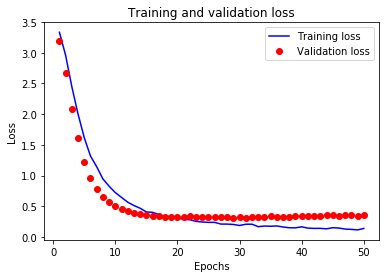

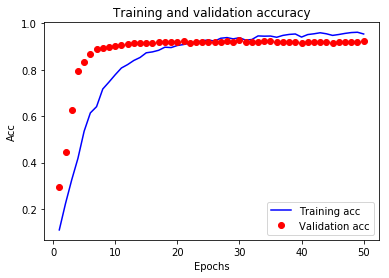

1200/1200 [==============================] - 2s 2ms/step

Results:
Train_acc: 0.841
Val_acc: 0.885
Test_acc: 0.922
F1-score: 0.922


In [16]:
plot_results(history)
evaluation()